In [13]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

from keras.applications.resnet50 import ResNet50
# define ResNet50 model
ResNet50_model_Dog = ResNet50(weights='imagenet')

from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model_Dog.predict(img))

### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
ResNet50_model = Sequential()
ResNet50_model.add(GlobalAveragePooling2D(input_shape=(1, 1, 2048)))
ResNet50_model.add(Dense(133, activation='softmax'))
ResNet50_model.load_weights('saved_models/weights.best.ResNet50.hdf5')

from extract_bottleneck_features import *
def ResNet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = ResNet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

def dog_breed_classifier(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    if (dog_detector(img_path)):
        print('Hello,Doggy!')
        plt.imshow(img)
        print('You look like a ...')
        print(ResNet50_predict_breed(img_path))
    elif (face_detector(img_path)):
        print('Hello, human!')
        plt.imshow(img)
        print('You look like a ...')
        print(ResNet50_predict_breed(img_path))
    else:
        plt.imshow(img)
        print('ERROR, NO DOG OR HUMAN IN THE PICTURE')

Hello, human!
You look like a ...
Basenji


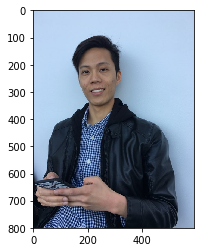

In [15]:
dog_breed_classifier('images/pingYi.jpg')